# Import Libraries

In [43]:
import kagglehub


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score


path = kagglehub.dataset_download("prajitdatta/movielens-100k-dataset")
print("Dataset Path:", path)

Using Colab cache for faster access to the 'movielens-100k-dataset' dataset.
Dataset Path: /kaggle/input/movielens-100k-dataset


#Load Dataset

In [34]:
ratings = pd.read_csv(path + "/ml-100k/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])
movies = pd.read_csv(path + "/ml-100k/u.item", sep="|", encoding="latin-1",
                     names=["movie_id", "title"] + [f"col{i}" for i in range(22)], usecols=[0,1])

# Merge ratings + movies
df = pd.merge(ratings, movies, on="movie_id")
print(df.head())

   user_id  movie_id  rating  timestamp                       title
0      196       242       3  881250949                Kolya (1996)
1      186       302       3  891717742    L.A. Confidential (1997)
2       22       377       1  878887116         Heavyweights (1994)
3      244        51       2  880606923  Legends of the Fall (1994)
4      166       346       1  886397596         Jackie Brown (1997)


#Data Exploration


Ratings Summary:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


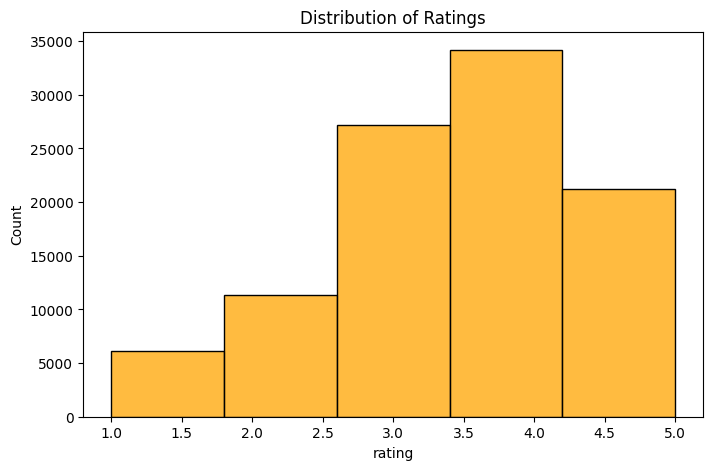

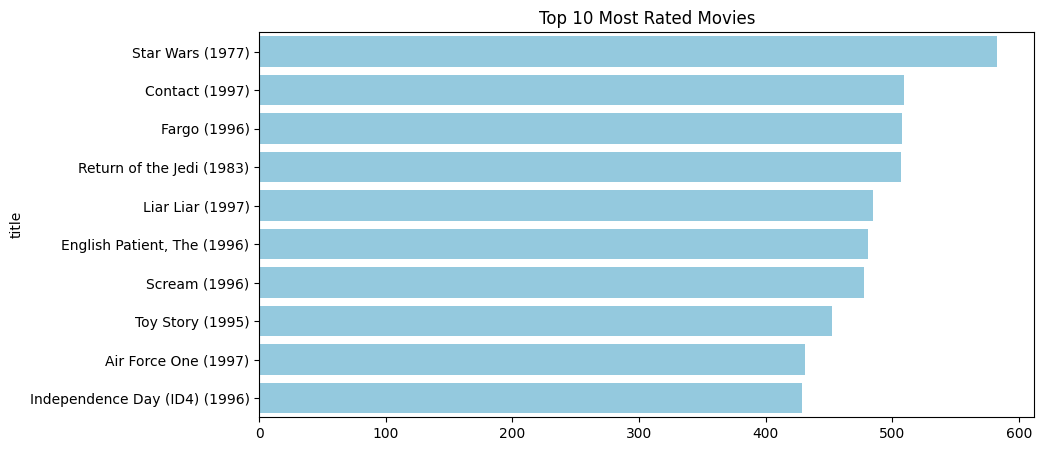

In [35]:
print("\nRatings Summary:")
print(df["rating"].describe())

plt.figure(figsize=(8,5))
sns.histplot(df["rating"], bins=5, kde=False, color="orange")
plt.title("Distribution of Ratings")
plt.show()

top_movies = df["title"].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_movies.values, y=top_movies.index, color="skyblue")
plt.title("Top 10 Most Rated Movies")
plt.show()

#Create User-Item Matrix

In [36]:
user_item_matrix = df.pivot_table(index="user_id", columns="title", values="rating")
print("\n User-Item Matrix Shape:", user_item_matrix.shape)


 User-Item Matrix Shape: (943, 1664)


#User Similarity

In [37]:
# Fill missing ratings with 0
user_item_filled = user_item_matrix.fillna(0)
user_similarity = cosine_similarity(user_item_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

print("\nUser Similarity Matrix Example:")
print(user_similarity_df.head())


User Similarity Matrix Example:
user_id       1         2         3         4         5         6         7    \
user_id                                                                         
1        1.000000  0.168937  0.048388  0.064561  0.379670  0.429682  0.443097   
2        0.168937  1.000000  0.113393  0.179694  0.073623  0.242106  0.108604   
3        0.048388  0.113393  1.000000  0.349781  0.021592  0.074018  0.067423   
4        0.064561  0.179694  0.349781  1.000000  0.031804  0.068431  0.091507   
5        0.379670  0.073623  0.021592  0.031804  1.000000  0.238636  0.374733   

user_id       8         9         10   ...       934       935       936  \
user_id                                ...                                 
1        0.320079  0.078385  0.377733  ...  0.372213  0.119860  0.269860   
2        0.104257  0.162470  0.161273  ...  0.147095  0.310661  0.363328   
3        0.084419  0.062039  0.066217  ...  0.033885  0.043453  0.167140   
4        0.188060  

#Recommendation Function

In [44]:
def recommend_movies(user_id, top_n=5):
    sim_scores = user_similarity_df[user_id]

    similar_users = sim_scores.drop(user_id).sort_values(ascending=False).head(5).index

    similar_users_ratings = user_item_matrix.loc[similar_users]
    mean_ratings = similar_users_ratings.mean(axis=0)

    user_seen = user_item_matrix.loc[user_id].dropna().index
    recommendations = mean_ratings.drop(user_seen).sort_values(ascending=False).head(top_n)

    return recommendations

#Test Recommendation

In [39]:
for i in range(10):
  print("\nRecommendations for User", i+1)
  print(recommend_movies(i+1, top_n=5))


Recommendations for User 1
title
Alien: Resurrection (1997)           5.0
Wings of Desire (1987)               5.0
Titanic (1997)                       5.0
City of Lost Children, The (1995)    5.0
Sophie's Choice (1982)               5.0
dtype: float64

Recommendations for User 2
title
Amistad (1997)               5.0
Boot, Das (1981)             5.0
Dangerous Beauty (1998)      5.0
Swingers (1996)              5.0
Mr. Holland's Opus (1995)    5.0
dtype: float64

Recommendations for User 3
title
Fire Down Below (1997)                         5.0
Incognito (1997)                               5.0
Star Kid (1997)                                5.0
Mrs. Brown (Her Majesty, Mrs. Brown) (1997)    5.0
Wonderland (1997)                              5.0
dtype: float64

Recommendations for User 4
title
Game, The (1997)            5.000000
Edge, The (1997)            4.333333
Ice Storm, The (1997)       4.250000
L.A. Confidential (1997)    4.250000
Dante's Peak (1997)         4.000000
dtype: fl

#Evaluate Precision at K

In [47]:
def precision_at_k(user_id, k=5, threshold=3.5):
    recs = recommend_movies(user_id, top_n=k)
    relevant = df[(df["user_id"] == user_id) & (df["rating"] >= threshold)]["title"].tolist()
    recommended = recs.index.tolist()

    if not relevant:
        return None  # user has no relevant items

    hits = len(set(recommended) & set(relevant))
    return hits / k

scores = []
for u in df["user_id"].unique()[:100]:  # evaluate on first 100 users
    p = precision_at_k(u, k=5)
    if p is not None:
        scores.append(p)

print("\n Average Precision at 5:", np.mean(scores))


 Average Precision at 5: 0.0


#Item-based Collaborative Filtering

In [48]:
item_similarity = cosine_similarity(user_item_filled.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

def recommend_item_based(user_id, top_n=5):
    user_ratings = user_item_matrix.loc[user_id].dropna()
    scores = {}

    for movie, rating in user_ratings.items():
        similar_movies = item_similarity_df[movie].drop(movie)
        for sim_movie, sim_score in similar_movies.items():
            if sim_movie not in user_ratings.index:
                scores[sim_movie] = scores.get(sim_movie, 0) + sim_score * rating

    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return pd.Series(dict(sorted_scores[:top_n]))

# Example recommendations for first 10 users
for i in range(10):
  print("\nItem-Based Recommendations for User", i+1)
  print(recommend_item_based(i+1, top_n=5))


Item-Based Recommendations for User 1
E.T. the Extra-Terrestrial (1982)    392.868044
Stand by Me (1986)                   366.958476
Speed (1994)                         366.715440
Batman (1989)                        363.956465
True Lies (1994)                     362.610997
dtype: float64

Item-Based Recommendations for User 2
Return of the Jedi (1983)        79.869941
Twelve Monkeys (1995)            76.625365
Independence Day (ID4) (1996)    76.532845
Rock, The (1996)                 76.482188
Dead Man Walking (1995)          73.901361
dtype: float64

Item-Based Recommendations for User 3
Titanic (1997)                 48.706770
English Patient, The (1996)    43.550033
Apt Pupil (1998)               41.704825
Full Monty, The (1997)         41.262224
Saint, The (1997)              40.874115
dtype: float64

Item-Based Recommendations for User 4
Return of the Jedi (1983)      33.628571
Titanic (1997)                 33.581291
L.A. Confidential (1997)       32.776094
Game, The (1997)

#Matrix Factorization (SVD)

In [42]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, random_state=42)
latent_matrix = svd.fit_transform(user_item_filled)

print("\n Latent Matrix Shape:", latent_matrix.shape)


 Latent Matrix Shape: (943, 20)
